### 循环神经网络模型模型：Encoder-Decoder with LSTM cell


In [28]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

random.seed(42)

读取数据

In [3]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/decay_result.array'
transplant_arr_path = r'../output/transplant/decay_result.array'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)


### 截断数据
因2019年两个数据集的EmergingScore大部分都为0，而2018年及之前的情况要好很多，故抛弃2019年数据

In [4]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 11)
Shape of the transplant array: (5141, 16, 11)


### 规范数据并获取训练集和测试集

In [5]:
scaler, data = scale_data(transplant_arr, 'standard')
X_train, X_test, y_train, y_test = split_data(data, 11, 0.2)

### 构建模型

In [14]:
def build_encoder_decoder_model(lstm_units, dense_units, lr):
    model = keras.models.Sequential()
    model.add(LSTM(lstm_units, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh'))
    model.add(RepeatVector(y_train.shape[1]))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(LSTM(lstm_units, activation='tanh', return_sequences=True))
    model.add(TimeDistributed(Dense(dense_units, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    
    optimizer=keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mae', optimizer='adam')
    return model

训练

In [7]:
model = build_encoder_decoder_model()
history = model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1, validation_data=(X_test, y_test), 
                   callbacks=[])

Train on 4112 samples, validate on 1029 samples
Epoch 1/20
4112/4112 [==============================] - 29s 7ms/sample - loss: 0.5511 - val_loss: 0.5048
Epoch 2/20
4112/4112 [==============================] - 18s 4ms/sample - loss: 0.5366 - val_loss: 0.4960
Epoch 3/20
4112/4112 [==============================] - 16s 4ms/sample - loss: 0.5285 - val_loss: 0.4956
Epoch 4/20
4112/4112 [==============================] - 16s 4ms/sample - loss: 0.5264 - val_loss: 0.4872
Epoch 5/20
4112/4112 [==============================] - 16s 4ms/sample - loss: 0.5224 - val_loss: 0.4852
Epoch 6/20
4112/4112 [==============================] - 16s 4ms/sample - loss: 0.5219 - val_loss: 0.4820
Epoch 7/20
4112/4112 [==============================] - 16s 4ms/sample - loss: 0.5208 - val_loss: 0.4885
Epoch 8/20
4112/4112 [==============================] - 16s 4ms/sample - loss: 0.5201 - val_loss: 0.4806
Epoch 9/20
4112/4112 [==============================] - 16s 4ms/sample - loss: 0.5177 - val_loss: 0.4797
Epoch 1

预测

from tensorflow.keras.models import load_model

model = load_model(r'C:\Users\Tom Leung\Desktop\best.h5')
y_pred = model.predict(X_test).reshape(y_test.shape)

MAE: 0.6794559374706024
MAEMAE: [0.63497424 0.67648521 0.69046514 0.68099779 0.7143573 ]


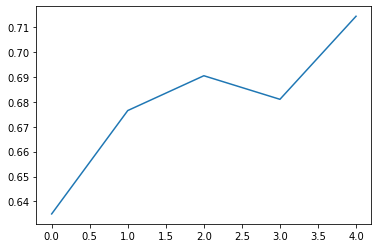

MSE: 1.450288355997312
MSEMAE: [1.39966462 1.50869504 1.6387495  1.21824771 1.48608491]


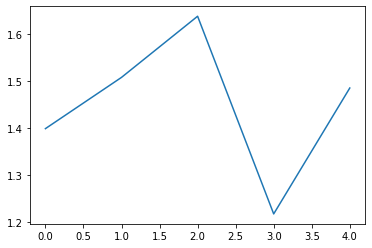

MAPE: 13783104214.110168
MAPEMAE: [2.37637454e+10 3.54657275e+10 4.84243907e+09 4.84360914e+09
 9.27147514e-01]


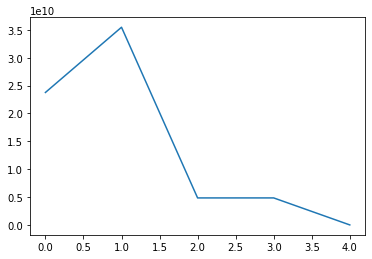

RMSE: 1.2042791852379215
RMSEMAE: [1.18307422 1.22828948 1.28013652 1.10374259 1.21905082]


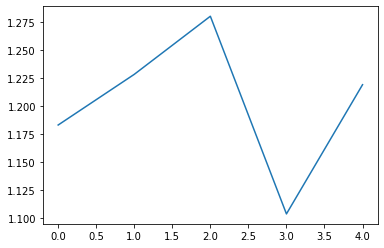

NDCG: 0.8529643085037936
NDCGMAE: [0.6302062234072997, 0.42137539145334685, 0.406936093257541, 0.5936737446070284, 0.46501339431161404]


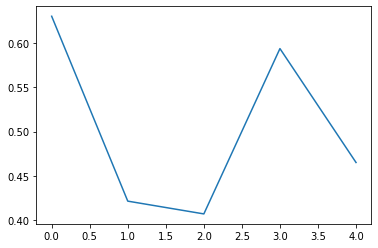

In [33]:
ids = random.sample(range(len(y_test)), 10)

plt.figure(figsize=(12,8))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_test[ids[i]].reshape(-1)), axis=None), label='actual', zorder=1)
    plt.plot(np.concatenate((X_test[ids[i], :, -2], y_pred[ids[i]].reshape(-1)), axis=None), label='predict', zorder=0)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:
_y_true, _y_pred = eval_model('classification', y_test, y_pred, scaler)

In [14]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         0.0       0.42      1.00      0.59        27
         1.0       0.69      0.67      0.68      3248
         2.0       0.18      0.18      0.18      1059
         3.0       0.40      0.34      0.37       548
         4.0       0.21      0.28      0.24       263

    accuracy                           0.52      5145
   macro avg       0.38      0.50      0.41      5145
weighted avg       0.53      0.52      0.52      5145



In [35]:
from sklearn.metrics import classification_report
print(classification_report(_y_true.reshape(-1), _y_pred.reshape(-1)))

              precision    recall  f1-score   support

         1.0       0.72      0.79      0.75      3275
         2.0       0.33      0.03      0.05      1059
         3.0       0.00      0.00      0.00       548
         4.0       0.12      0.65      0.20       263

    accuracy                           0.54      5145
   macro avg       0.29      0.37      0.25      5145
weighted avg       0.53      0.54      0.50      5145



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
